## Intro
This code shows an example of using OWAD upon **normal-confidence** anomaly detection models. Here we use a Log Anomaly Detection case with `DeepLog` (aka LSTM) as the anomaly detection model and `BGL` as the log dataset.


In [1]:
%load_ext autoreload
%autoreload 2
## import packages
import sys
sys.path.append('../admodels/')
sys.path.append('../moudles/')
sys.path.append('../baselines/')
sys.path.append('../')
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import _pickle as pkl
import DeepLog
from calibrator import Calibrator
from shifthunter import ShiftHunter
import myutils as utils

In [2]:
# Load control and treatment data
con_seq = np.load('data/logad_con.npz')
X_ic, X_oc, y_c = con_seq['input'], con_seq['output'], con_seq['label']
tre_seq = np.load('data/logad_tre.npz')
X_it, X_ot, y_t = tre_seq['input'], tre_seq['output'], tre_seq['label']

## Prepare AD model and data

In [3]:
# training DeepLog model
utils.set_random_seed()
train_num = 100000
X_train = {'input':X_ic[y_c==0][:train_num], 'output':X_oc[y_c==0][:train_num]}
model = DeepLog.train(X_train)

Epoch [1/20], train_loss: 3.1481
Epoch [2/20], train_loss: 1.3317
Epoch [3/20], train_loss: 1.0705
Epoch [4/20], train_loss: 0.8074
Epoch [5/20], train_loss: 0.6328
Epoch [6/20], train_loss: 0.4127
Epoch [7/20], train_loss: 0.3123
Epoch [8/20], train_loss: 0.2606
Epoch [9/20], train_loss: 0.2238
Epoch [10/20], train_loss: 0.2001
Epoch [11/20], train_loss: 0.1839
Epoch [12/20], train_loss: 0.1724
Epoch [13/20], train_loss: 0.1647
Epoch [14/20], train_loss: 0.1574
Epoch [15/20], train_loss: 0.1522
Epoch [16/20], train_loss: 0.1475
Epoch [17/20], train_loss: 0.1424
Epoch [18/20], train_loss: 0.1395
Epoch [19/20], train_loss: 0.1360
Epoch [20/20], train_loss: 0.1329
Finished Training


In [4]:
## test performance at control set and treament set (testing data)
pred_con, prob_con = DeepLog.test(model, {'input':X_ic, 'output':X_oc})
print('Test in Control set:')
print('f1-score:', metrics.f1_score(y_c, pred_con),
      'precision:', metrics.precision_score(y_c, pred_con),
      'recall:', metrics.recall_score(y_c, pred_con)
     )

pred_tre, prob_tre = DeepLog.test(model, {'input':X_it, 'output':X_ot})
print('Test in Treatment set:')
print('f1-score:', metrics.f1_score(y_t, pred_tre), 
      'precision:', metrics.precision_score(y_t, pred_tre),
      'recall:', metrics.recall_score(y_t, pred_tre)
     )

Test in Control set:
f1-score: 0.8915540967049614 precision: 0.8858504766683392 recall: 0.8973316391359594
Test in Treatment set:
f1-score: 0.44641499873321505 precision: 0.296932928884395 recall: 0.8989795918367347


**(As we can see that, the performance decreases sharply from 0.89 to 0.44)**

In [6]:
## get validation data of control set and treament set
vali_num = 100000
X_con, y_con = {'input':X_ic[:vali_num], 'output':X_oc[:vali_num]}, y_c[:vali_num]
X_tre, y_tre = {'input':X_it[:vali_num], 'output':X_ot[:vali_num]}, y_t[:vali_num]
prob_con = prob_con[:vali_num]
prob_tre = prob_tre[:vali_num]

## Let's use OWAD！

NOTICE: Initialize OWAD Calibrator Under **Isotonic** Method!
NOTICE: uncalibrated Probs is **BENIGN** confidence
NOTICE: Initilize OWAD Shift Handler Under **Seq** Mode!
Shift! P-value is 0.000999000999000999
Visualize Shift:


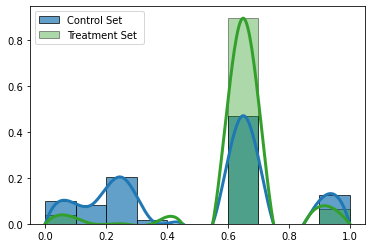

In [7]:
utils.set_random_seed()

## detect shift with OWAD
cb = Calibrator(X_con, method='Isotonic')
cb.set_calibrator(prob_con, is_P_mal=False)
sh = ShiftHunter(prob_con, prob_tre, cb, ad_type='Seq')
t = utils.get_params('ShiftDetector')['test_thres']
p_value = sh.permu_test()
if p_value >= t:
    print("Non-shift, skip explain and adaptation!")
else:
    print('Shift! P-value is', p_value)
print("Visualize Shift:")
sh.visualize_hists()

In [8]:
utils.set_random_seed()

## explain and adapt to shift with OWAD
ohd_bgt = 30000
exp_result = sh.explainer(X_tre, y_tre, label_num = ohd_bgt) # , auto_cali_thres=True
sh.adapter(model)

step:0 |Loss:16.0000 |Accuracy_Loss:1.0000 |Overhead_Loss:1.0000 |Determinism_Loss:1.0000 |M_c num: 50203 |M_t num: 49834
step:10 |Loss:15.6083 |Accuracy_Loss:0.9422 |Overhead_Loss:0.9883 |Determinism_Loss:1.0145 |M_c num: 49646 |M_t num: 49279
step:20 |Loss:15.2432 |Accuracy_Loss:0.8893 |Overhead_Loss:0.9771 |Determinism_Loss:1.0253 |M_c num: 49152 |M_t num: 48621
step:30 |Loss:14.8909 |Accuracy_Loss:0.8381 |Overhead_Loss:0.9668 |Determinism_Loss:1.0327 |M_c num: 48613 |M_t num: 47924
step:40 |Loss:14.5496 |Accuracy_Loss:0.7881 |Overhead_Loss:0.9572 |Determinism_Loss:1.0373 |M_c num: 48264 |M_t num: 47097
step:49 |Loss:14.2518 |Accuracy_Loss:0.7441 |Overhead_Loss:0.9492 |Determinism_Loss:1.0391 |M_c num: 47918 |M_t num: 46236
get X_c, X_t (len): 100000 100000
** Cliping <remain_X_t> ...
NOTICE: simulating labelling...
Filter 11 anomalies in remain_X_tre
Remain X_c, X_t (len): 52078 29989
Adapter: Begin Processing ... 
Estimating Params Weight:0/8207
Estimating Params Weight:1000/8207


In [9]:
## Test the performance after OWAD adaptation
print('After OWAD Adaptation:')
pred_tre, prob_tre = DeepLog.test(sh.model, {'input':X_it, 'output':X_ot})
print('f1-score:', metrics.f1_score(y_t, pred_tre),
      'precision:', metrics.precision_score(y_t, pred_tre),
      'recall:', metrics.recall_score(y_t, pred_tre)
     )

After OWAD Adaptation:
f1-score: 0.7849954254345837 precision: 0.7114427860696517 recall: 0.8755102040816326


**(As we can see that, OWAD Adaptation significantly improves the performance of AD models from 0.44 to 0.78 with 30k labels, which is 30% of validation set and 15% of testing set)**

### Compared with retraining

In [20]:
utils.set_random_seed()

## retraining with all old samples and `ohd_bgt` new samples 
X_retrain = {'input': np.concatenate((X_ic[y_c==0][:train_num], X_tre['input'][:ohd_bgt])),
             'output': np.concatenate((X_oc[y_c==0][:train_num], X_tre['output'][:ohd_bgt]))}
retrain_model = DeepLog.train(X_retrain)

## test the performance of retraining model
pred_tre, prob_tre = DeepLog.test(retrain_model, {'input':X_it, 'output':X_ot})
print('After Retraining:')
print('f1-score:', metrics.f1_score(y_t, pred_tre), 
      'precision:', metrics.precision_score(y_t, pred_tre),
      'recall:', metrics.recall_score(y_t, pred_tre)
     )

Epoch [1/20], train_loss: 2.4513
Epoch [2/20], train_loss: 0.7219
Epoch [3/20], train_loss: 0.5771
Epoch [4/20], train_loss: 0.3821
Epoch [5/20], train_loss: 0.2326
Epoch [6/20], train_loss: 0.1824
Epoch [7/20], train_loss: 0.1577
Epoch [8/20], train_loss: 0.1430
Epoch [9/20], train_loss: 0.1329
Epoch [10/20], train_loss: 0.1260
Epoch [11/20], train_loss: 0.1203
Epoch [12/20], train_loss: 0.1159
Epoch [13/20], train_loss: 0.1124
Epoch [14/20], train_loss: 0.1095
Epoch [15/20], train_loss: 0.1067
Epoch [16/20], train_loss: 0.1041
Epoch [17/20], train_loss: 0.1020
Epoch [18/20], train_loss: 0.1000
Epoch [19/20], train_loss: 0.0982
Epoch [20/20], train_loss: 0.0959
Finished Training
After Retraining:
f1-score: 0.44053985230455817 precision: 0.29351883271123175 recall: 0.8826530612244898


**The result shows that retraining fails to improve the performance in this case.**